### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12423
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1219.2|   37.75|  -117.65|       TMAX|USC00267465|    43|[30 55 40 56 80 5...|1898.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       TMAX|USC00045352|     3|[00 58 50 57 E0 5...|2007.0|SSSBSSBB|
|   1219.2|   37.75|  -117.65|       TMIN|USC00267465|    45|[90 D5 E0 D5 40 D...|1898.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       TMIN|USC00045352|    24|[00 46 00 46 E0 5...|2007.0|SSSBSSBB|
|   1452.4| 37.9747|-119.9161|       TMAX|USC00041697|     0|[80 54 00 53 80 5...|1956.0|SSSBSSBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [17]:
sqlContext.registerDataFrameAsTable(df,'weather')
meas='TOBS'
q = "SELECT station, COUNT(station) as count0 FROM weather WHERE measurement = '%s' GROUP BY station ORDER BY count0 DESC"%(meas)
df_temp = sqlContext.sql(q)
df_temp.show(5)

+-----------+------+
|    station|count0|
+-----------+------+
|USC00263285|    80|
|USC00045532|    76|
|USC00262431|    63|
|USC00043939|    63|
|USC00048380|    61|
+-----------+------+
only showing top 5 rows



In [19]:
sqlContext.registerDataFrameAsTable(df,'weather')
meas='TOBS'
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%(meas,'USC00043939')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00043939'
63 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1179.6| 37.9614|-119.7831|       TOBS|USC00043939|     0|[30 54 00 00 00 0...|1911.0|SSSBSSBB|
|   1179.6| 37.9614|-119.7831|       TOBS|USC00043939|     1|[80 49 00 D3 F0 D...|1949.0|SSSBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(63L, 365L)

### Script for plotting yearly plots

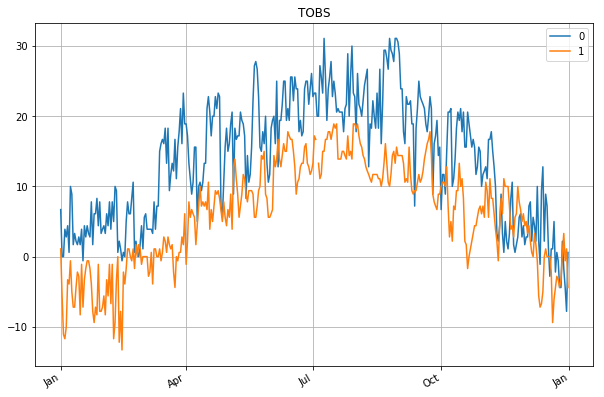

In [20]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TOBS')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/home/pdak/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


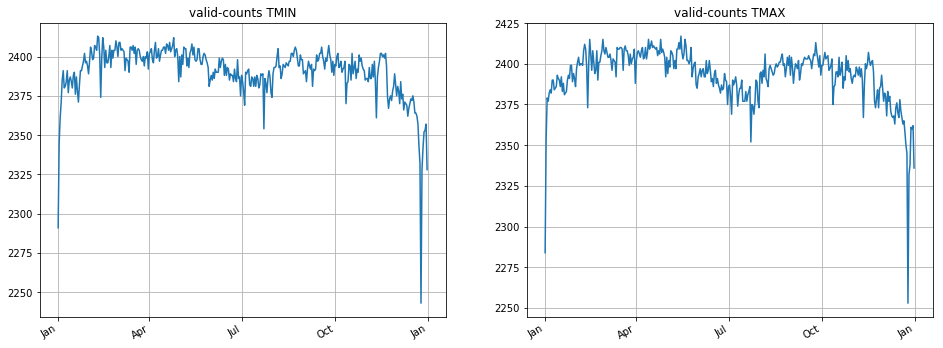

In [10]:
plot_pair(['TMIN','TMAX'],plot_valid)

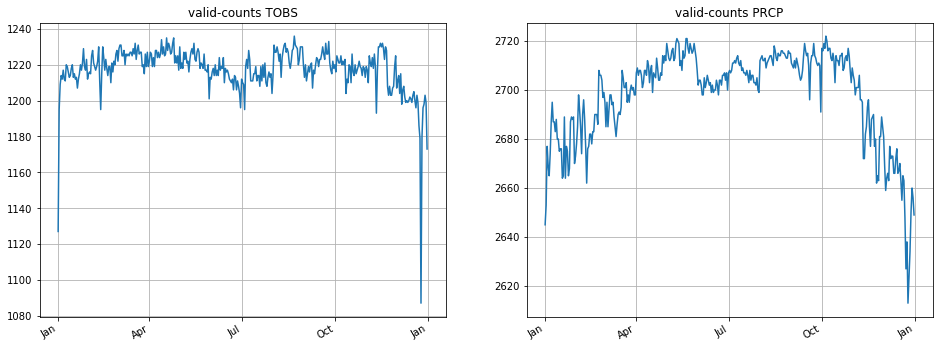

In [11]:
plot_pair(['TOBS','PRCP'],plot_valid)

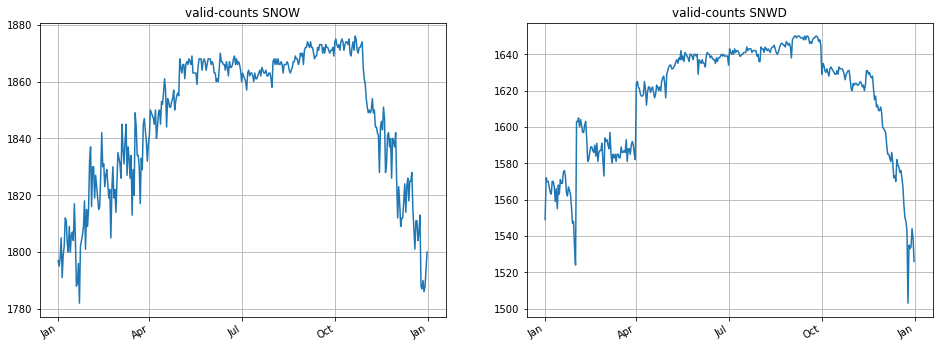

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [26]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    mean=mean*1.1833
    std=np.sqrt(STAT[m]['Var'])
    std=std*1.1833
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

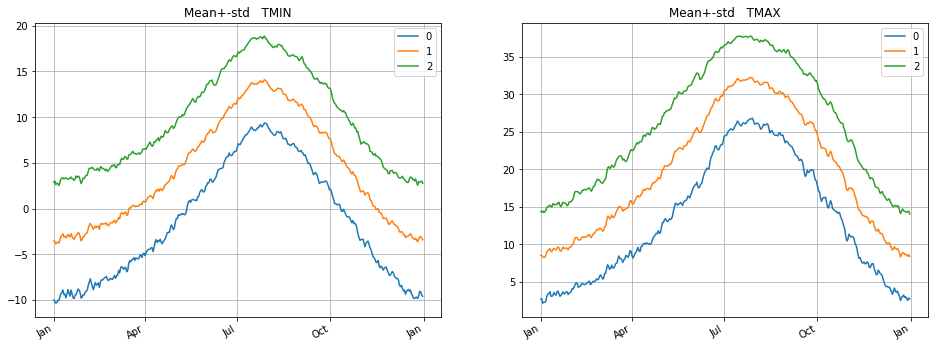

In [23]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

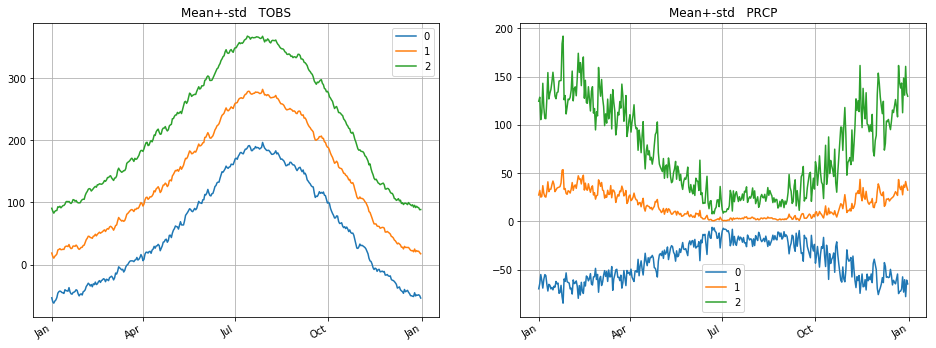

In [27]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

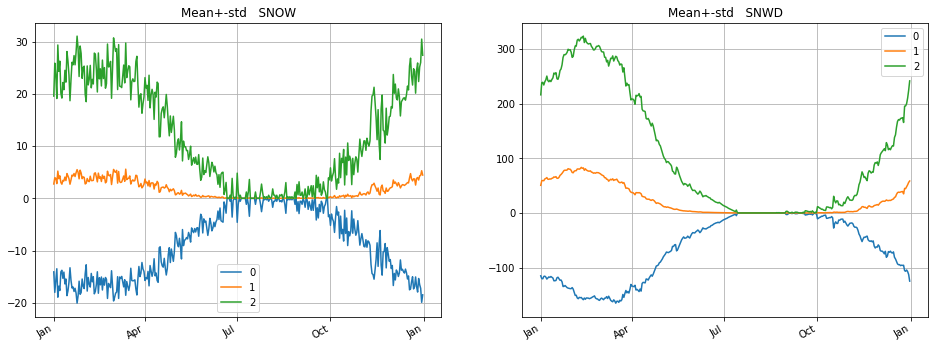

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [7]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

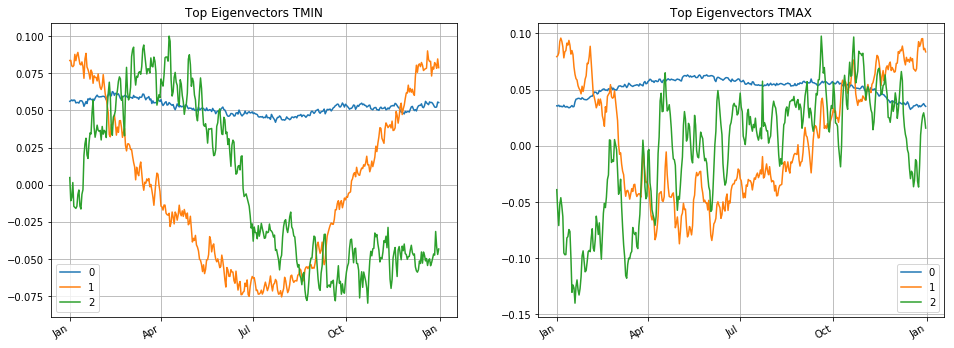

In [18]:
plot_pair(['TMIN','TMAX'],plot_eigen)

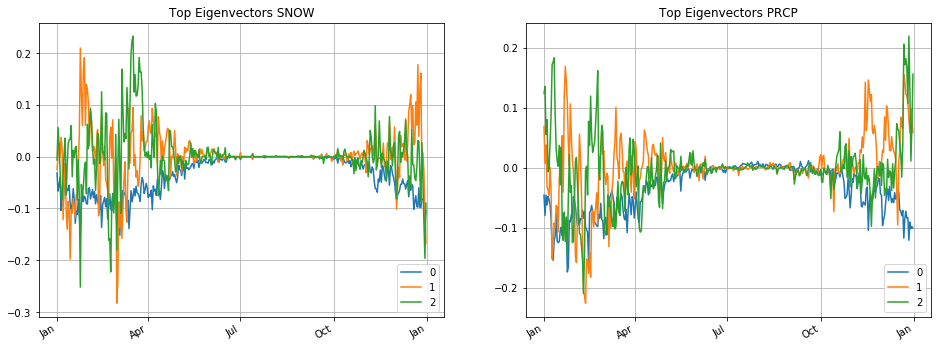

In [9]:
plot_pair(['SNOW','PRCP'],plot_eigen)

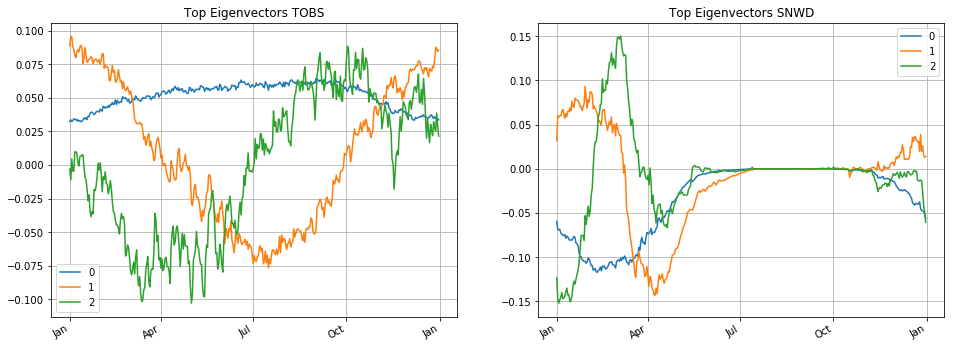

In [8]:
plot_pair(['TOBS', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [11]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

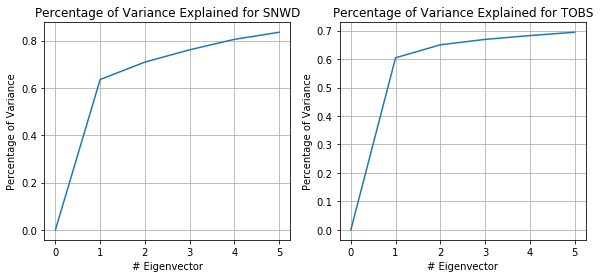

In [12]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNWD', 'TOBS']: #,
    pltVarExplained(j)
    j+=1

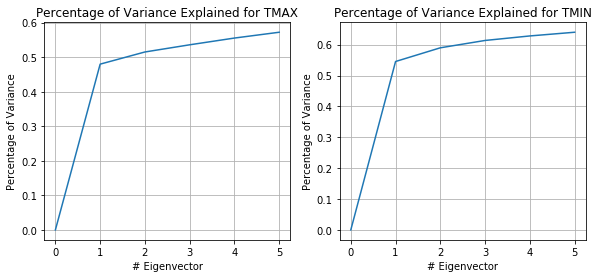

In [14]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMAX','TMIN']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()

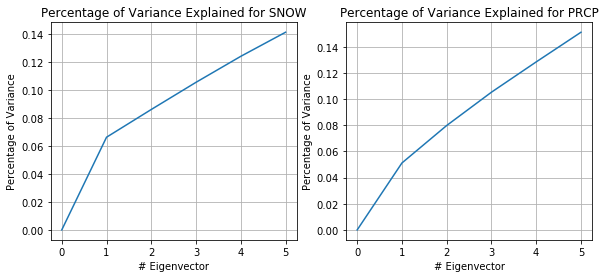

In [15]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW','PRCP']:
    pltVarExplained(j)
    j+=1 